# Chapter 6 决策树

## Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 1. 训练和可视化的一个决策树（Training and Visualizing a Decision Tree）

要理解决策树，让我们构建一个，并看看它是如何进行预测的。下面的代码在鸢尾花数据集上训练决策树分类器（参见第4章）：

In [5]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)

X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values

y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

您可以首先通过使用 **export_graphviz()** 函数输出一个名为 **iris_tree.dot** 的图定义文件来可视化训练过的决策树：

In [6]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=str(IMAGES_PATH / "iris_tree.dot"),  # path differs in the book
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

然后你可以使用 **graphviz.Source.from_file()** 加载并显示该文件：

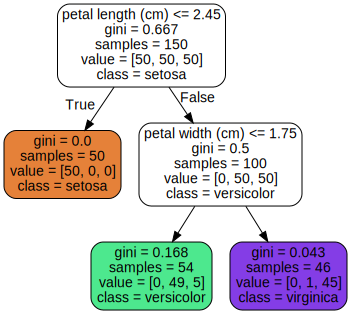

In [7]:
from graphviz import Source

Source.from_file(IMAGES_PATH / "iris_tree.dot")  # path differs in the book

Graphviz 是一个开源的图形可视化软件包。它还包括一个 **dot** 命令行工具，用于将 **.dot** 文件转换为各种格式，如 **PDF** 或 **PNG** 。

以下命令将 dot 文件转换为 png 图像：

In [8]:
# extra code
!dot -Tpng {IMAGES_PATH / "iris_tree.dot"} -o {IMAGES_PATH / "iris_tree.png"}

## 2. 进行预测（Making Predictions）

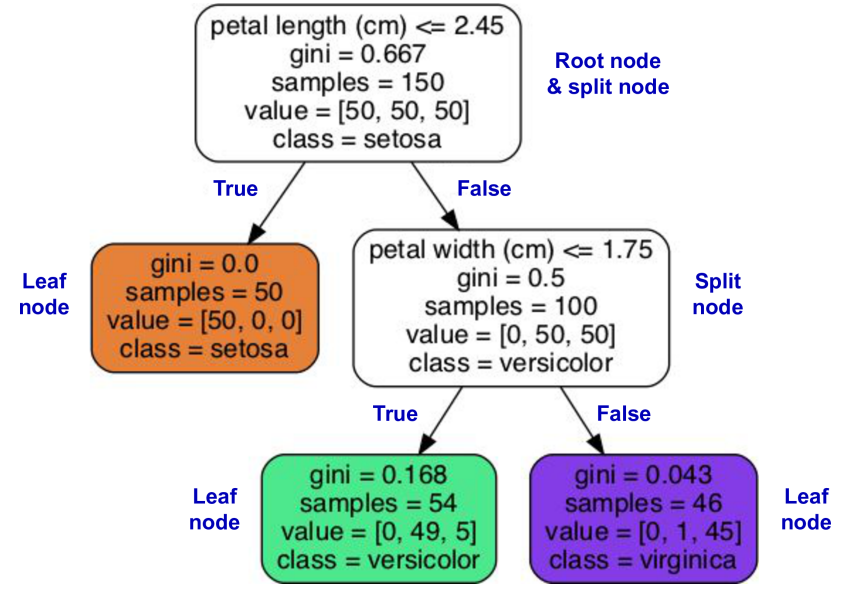

让我们看看上图中表示的树是如何做出预测的。假设你找到了一朵鸢尾花，你想根据它的花瓣对它进行分类。您从根节点（深度0，位于顶部）开始：此节点询问花的花瓣长度是否小于2.45厘米。如果是，则将向下移动到根节点的左子节点（深度1，左侧）。在这种情况下，它是一个叶节点（即，它没有任何子节点），所以它不问任何问题：只需查看该节点的预测类，决策树预测您的花是 Iris setosa（**class=setosa**）。

现在假设你找到了另一朵花，这次是花瓣的长度大于2.45厘米。您再次从根节点开始，但现在向下移动到右侧的子节点（深度1，右侧）。这不是一个叶节点，它是一个分裂的节点，所以它问了另一个问题：花瓣的宽度是否小于1.75厘米？如果是，那么你的花很可能是 Iris versicolor（深度2，左）。如果不是，它很可能是 Iris virginica（深度2，右）。就是那么简单。

**注意**：决策树的许多特性之一是，它们只需要很少的数据准备。事实上，它们根本不需要特征缩放或中心化。

一个节点的 **samples** 属性计算它应用于多少个训练实例。例如，100个训练实例的花瓣长度大于2.45厘米（深度1，右），在这100个训练实例中，54个的花瓣宽度小于1.75厘米（深度2，左）。节点的值属性告诉您这个节点适用于每个类的多少个训练实例：例如，右下角的节点应用于0个 Iris setosa 、1个 Iris versicolor 和45个 Iris virginica 。最后，一个节点的 **gini** 属性度量它的 **基尼不纯度（Gini impurity）** ：如果一个节点应用的所有训练实例都属于同一类，那么该节点就是“纯的”（**gini=0**）。例如，由于深度为1的左节点只适用于Iris setosa训练实例，因此它是纯的，其基尼不纯度为0。

如下显示了训练算法如何计算第 $i$ 个节点的基尼不纯度 $G_i$ 。深度为2的左侧节点的基尼不纯度等于 $1-(0/54)^2-(49/54)^2-(5/54)^2\approx 0.168$ 。

**基尼不纯度（Gini impurity）**：

$$ G_i=1-\sum_{k=1}^np_{i,k}^2 $$

其中：
- $G_i$ 是第 $i$ 个节点的基尼不纯度。
- $p_{i,k}$ 是第 $i$ 个节点在训练实例中类别 $k$ 的比例。

**注意**：Scikit-Learn 使用 CART 算法，它只产生二叉树，这意味着分割节点总是恰好有两个子节点的树（即，问题只有是/否的答案）。然而，其他算法，如 ID3 ，可以产生具有两个以上子节点的决策树。

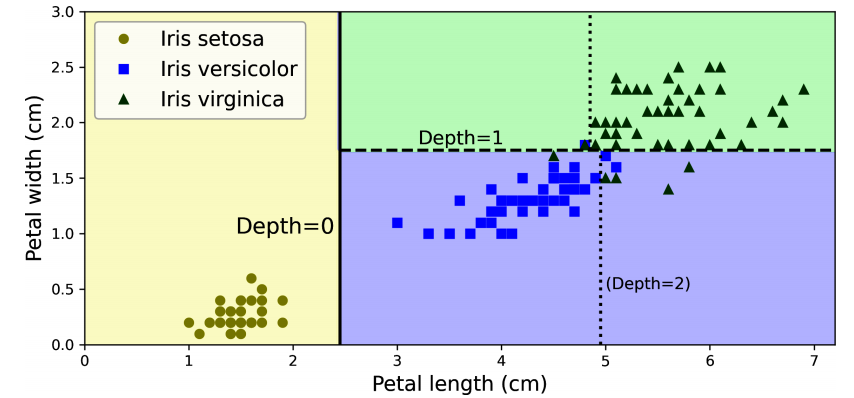

上图显示了此决策树的决策边界。粗竖线表示根节点的决策边界（深度0）：花瓣长度等于2.45 cm。由于左边的区域是纯的（只有Iris setosa），它不能再进一步分割。然而，右边的区域是不纯的，所以深度为1右边的节点分裂它在花瓣宽度等于1.75厘米（用水平虚线表示）。由于 **max_depth** 被设置为2，决策树就停止在那里。如果将 **max_depth** 设置为3，那么两个深度为2节点将分别添加另一个决策边界（由两条垂直虚线表示）。

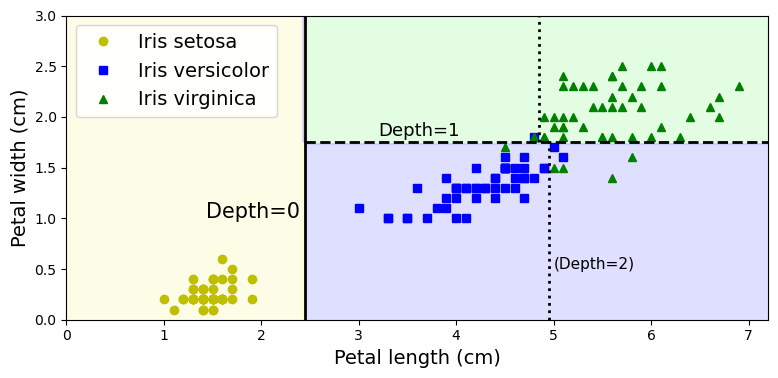

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# extra code – just formatting details
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

lengths, widths = np.meshgrid(np.linspace(0, 7.2, 100), np.linspace(0, 3, 100))
X_iris_all = np.c_[lengths.ravel(), widths.ravel()]
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

# extra code – this section beautifies and saves Figure 6–2
tree_clf_deeper = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf_deeper.fit(X_iris, y_iris)
th0, th1, th2a, th2b = tree_clf_deeper.tree_.threshold[[0, 2, 3, 6]]
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.plot([th0, th0], [0, 3], "k-", linewidth=2)
plt.plot([th0, 7.2], [th1, th1], "k--", linewidth=2)
plt.plot([th2a, th2a], [0, th1], "k:", linewidth=2)
plt.plot([th2b, th2b], [th1, 3], "k:", linewidth=2)
plt.text(th0 - 0.05, 1.0, "Depth=0", horizontalalignment="right", fontsize=15)
plt.text(3.2, th1 + 0.02, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.text(th2a + 0.05, 0.5, "(Depth=2)", fontsize=11)
plt.axis([0, 7.2, 0, 3])
plt.legend()
save_fig("decision_tree_decision_boundaries_plot")

plt.show()

**注意**：树的结构，包括上图中所示的所有信息，可以通过分类器的 **tree_** 属性获得。键入 **help(tree_clf.tree_)** 以了解详细信息，并参阅本章的笔记以了解示例。

In [10]:
tree_clf.tree_

In [11]:
help(sklearn.tree._tree.Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child 

**模型解释(白盒和黑盒)** ：决策树是直观的，它们的决策也很容易解释。这种模型通常被称为白盒模型。相比之下，正如您将看到的，随机森林和神经网络通常被认为是黑盒模型。他们做出了很好的预测，你可以很容易地检查他们为进行这些预测所做的计算；然而，通常很难用简单的术语来解释为什么要做出这些预测。例如，如果一个神经网络说一个特定的人出现在一张图片中，那就很难知道是什么促成了这个预测：这个模型是否重新识别了那个人的眼睛？他们的嘴吗？他们的鼻子吗？他们的鞋子？甚至是他们坐着的沙发？相反，决策树提供了漂亮的、简单的分类规则，如果需要，甚至可以手动应用（例如，用于花的分类）。可解释 ML 领域的目标是创建 ML 系统，以一种人类可以理解的方式来解释他们的决策。这在许多领域都很重要——例如，确保系统不会做出不公平的决定。

## 3. 估计类别概率（Estimating Class Probabilities）

决策树还可以估计一个实例属于一个特定类别 $k$ 的概率。首先，它遍历树以找到这个实例的叶节点，然后返回这个节点中类 $k$ 的训练实例的比率。例如，假设你发现了一朵花瓣长5厘米，宽1.5厘米的花。对应的叶节点为深度为2的左侧节点，因此决策树输出以下概率：Iris setosa 为 0%（0/54），Iris versicolor 为 90.7%（49/54），Iris virginica 为 9.3%（5/54）。如果你要求它来预测这个类，它会输出 Iris versicolor（第1类），因为它有最高的概率。让我们来检查一下：

In [12]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [13]:
tree_clf.predict([[5, 1.5]])

array([1])

完美！请注意，在右下角的矩形中，估计的概率将是相同的——例如，如果花瓣长6厘米，宽1.5厘米（尽管在这种情况下，它很可能是一个Iris virginica）。

## 4. CART 训练算法（The CART Training Algorithm）

Scikit-Learn 使用 **分类和回归树（Classification and Regression Tree，CART）** 算法来训练决策树（也称为“生长”树）。该算法的工作原理是，首先使用一个单一特征 $k$ 和一个阈值 $t_k$（例如，“花瓣长度≤2.45厘米”）将训练集分割成两个子集。它如何选择 $k$ 和 $t_k$ 呢？它搜索产生最纯的子集的 $(t,t_k)$ 对组，并根据它们的大小进行加权。

**CART 分类成本函数**：

$$ J(k,t_k)=\frac{m_{left}}{m}G_{left}+\frac{m_{right}}{m}G_{right} $$

其中：

- $G_{left}$ 或 $G_{right}$ 度量 left/right 子集的不纯度。
- $m_{left}$ 或 $m_{right}$ 是 left/right 子集中的实例数量。

一旦 CART 算法成功地将训练集一分为二，它就会使用相同的逻辑分割子集，然后是递归地分割子集，以此类推。一旦它达到最大深度（由 **max_depth** 超参数定义），或者如果它找不到一个将减少不纯度的分裂，它就会停止递归。其他一些超参数（稍后描述）控制额外的停止控制：**min_samples_split**、**min_samples_leaf**、**min_weight_fraction_leaf** 和 **max_leaf_nodes** 。

**注意**：正如您所看到的，CART 算法是一个贪婪的算法：它贪婪地在顶层搜索一个最优的分割，然后在随后的每个级别上重复这个过程。它不检查分裂是否会导致最低可能的杂质几个水平下降。贪婪算法通常会产生一个相当好但不能保证最优的解是最优的。不幸的是，找到最优的树是已知的一个 NP-complete 的问题。它需要 $O(exp(m))$ 时间，使得即使是小的训练集，问题也难以处理。这就是为什么我们在训练决策树时必须满足于一个“相当好的”的解决方案。

## 5. 计算复杂度（Computational Complexity）

做出预测需要从决策树的根遍历到一片叶子。决策树通常是近似平衡的，所以遍历决策树需要大致经过 $O(log_2(m))$ 个节点，其中 $log_2(m)$ 是 $m$ 关于2的对数，等于 $log(m)/log(2)$ 。因为每个节点只需要检查一个特征的值，总体预测复杂度为 $O(log_2(m))$ ，与特征的数量无关。因此，预测速度非常快，即使是在处理大型训练集时。

该训练算法比较了每个节点上的所有样本上的所有特征（如果设置了 **max_features** ，则更少）。比较每个节点上所有样本上的所有特征，得到的训练复杂度为 $O(n\times m\ log_2(m))$ 。

## 6. 基尼不纯度或熵（Gini Impurity or Entropy）

默认情况下，**DecisionTreeClassifier** 类使用基尼不纯度进行度量，但您可以通过将 **criterion** 超参数设置为“**entropy**”来选择熵不纯度度量。

熵的概念起源于热力学中作为分子无序的度量：当分子仍然有序时，熵接近于零。熵后来扩散到各种各样的领域，包括在香农的信息论中，它测量了一个信息的平均信息内容，就像我们在第四章中看到的那样。当所有消息都相同时，熵为零。在机器学习中，熵经常被用作不纯度度量：当一个集合只包含一个类的实例时，它的熵为零。

**第 $i$ 个节点的熵（Entropy）**：

$$ H_i=-\sum_{k=1,p_i\ne0,k\ne0}^np_{i,k}log_2(p_{i,k}) $$

例如，上图中深度为 2 的左侧节点的熵等于 $-(49/54)log_2(49/54)-(5/54)log_2(5/54)\approx 0.445$ 。

那么，你应该使用基尼不纯度还是熵呢？事实是，大多数情况下，这并没有产生很大的区别：它们会导致相似的树。基尼不纯度的计算速度稍快一些，所以它是一个很好的默认值。然而，当它们不同时，**基尼不纯度倾向于在树自己的分支中分离最常见的类**，而**熵倾向于产生稍微平衡的树**。

## 7. 正则化超参数（Regularization Hyperparameters）

决策树对训练数据做了很少的假设。如果不受约束，树状结构将适应于训练数据，非常紧密地贴近它——事实上，很可能是过拟合。这种模型通常被称为 **非参数模型（nonparametric model）** ，不是因为它没有任何参数（它通常有很多参数），而是因为参数的数量不是在训练之前确定的，所以模型结构可以自由地与数据紧密结合。相比之下，**参数模型（parametric model）**，如线性模型，具有预定数量的参数，因此其自由度是有限的，减少了过拟合的风险（但增加了欠拟合的风险）。

为了避免过拟合训练数据，您需要在训练期间限制决策树的自由度。正如你现在已经知道的，这被称为正则化。正则化超参数取决于所使用的算法，但您至少可以限制决策树的最大深度。在 Scikit-Learn 中，这是由 **max_depth** 超参数控制。默认值为“**None**”，表示无限制。降低 **max_depth** 将使模型正则化，从而降低过拟合的风险。

**DecisionTreeClassifier** 类有一些其他的参数，类似地限制了决策树的形状：

- **max_features**：在每个节点上进行拆分时评估的最大特征数
- **max_leaf_nodes**：叶节点的最大数量
- **min_samples_split**：一个节点在可以被分割之前必须具有的最小样本数
- **min_samples_leaf**：一个叶节点必须被创建的最小样本数量
- **min_weight_fraction_leaf**：与 min_samples_leaf 相同，但表示为加权实例总数的一部分

增加 **min_\*** 超参数或减少 **max_\*** 超参数将使模型正则化。

**注意**：其他算法的工作原理是首先不受限制地训练决策树，然后修剪（删除）不必要的节点。如果其提供的纯度改进在统计上不显着，则认为其子节点都是叶节点的节点是不必要的。标准统计检验，例如 $\chi^2$ 检验（卡方检验），用于估计改进纯粹是偶然结果的概率（称为原假设）。如果这个概率（称为 $p$ 值）高于给定阈值（通常为 5%，由超参数控制），则该节点被认为是不必要的，其子节点将被删除。修剪继续进行，直到所有不必要的节点都被修剪掉。

让我们在第5章中介绍的卫星数据集上测试正则化。我们将训练一个没有正则化的决策树，而另一个使用 **min_samples_leaf=5** 。下面是代码；图中显示了每棵树的决策边界：

In [15]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

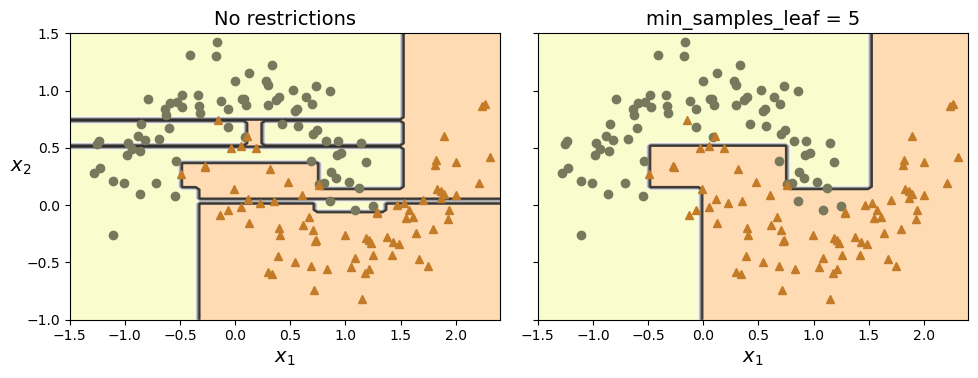

In [16]:
# extra code – this cell generates and saves Figure

def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf1, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title("No restrictions")
plt.sca(axes[1])
plot_decision_boundary(tree_clf2, X_moons, y_moons,
                       axes=[-1.5, 2.4, -1, 1.5], cmap="Wistia")
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("")
save_fig("min_samples_leaf_plot")
plt.show()

左边的非正则化模型明显是过拟合的，而右边的正则化模型可能会更好地推广。我们可以通过在使用不同的随机种子生成的测试集上评估这两棵树来验证这一点：

In [17]:
X_moons_test, y_moons_test = make_moons(n_samples=1000,
                                        noise=0.2,
                                        random_state=43)

tree_clf1.score(X_moons_test, y_moons_test)

0.898

In [18]:
tree_clf2.score(X_moons_test, y_moons_test)

0.92

事实上，第二棵树在测试集上有更好的精度。

## 8. 回归（Regression）

决策树也能够执行回归任务。让我们使用 Scikit-Learn 的 **DecisionTreeRegressor** 类构建一个回归树，在一个有噪声的二次数据集上训练它，**max_depth=2**：

In [19]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X_quad = np.random.rand(200, 1) - 0.5  # a single random input feature
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1)

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

生成的树被表示为：

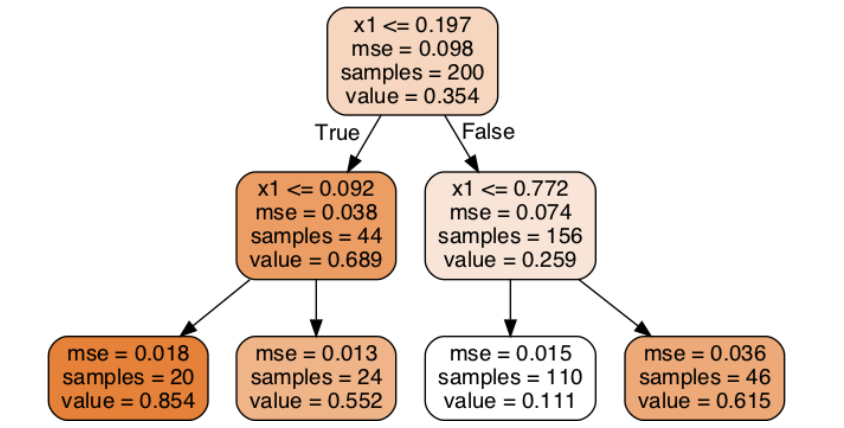

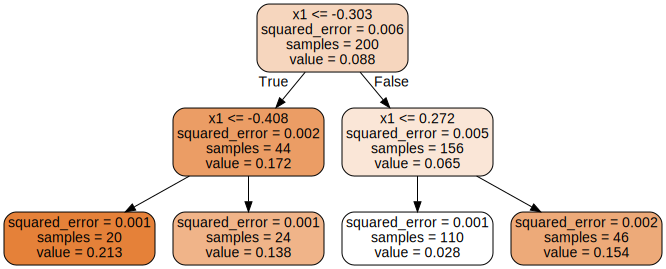

In [20]:
# extra code – we've already seen how to use export_graphviz()
export_graphviz(
    tree_reg,
    out_file=str(IMAGES_PATH / "regression_tree.dot"),
    feature_names=["x1"],
    rounded=True,
    filled=True
)
Source.from_file(IMAGES_PATH / "regression_tree.dot")

这棵树看起来与之前构建的分类树非常相似。主要的区别在于，它不是预测每个节点中的一个类，而是预测一个值。例如，假设您想对一个使用 $x_1 = 0.2$ 的新实例进行预测。根节点询问是否 $x_1≤0.197$ 。因为不是，算法转到右边的子节点，询问是否 $x_1≤0.772$ 。因为是，算法进入左子节点。这是一个叶节点，它可以预测到 $value=0.111$ 。该预测是与该叶节点相关联的110个训练实例的平均目标值，它导致这110个实例的均方误差等于 0.015 。

该模型的预测结果如左图所示。如果你设置了 **max_depth=3** ，你就会得到在右边表示的预测。请注意，每个区域的预测值总是该区域中实例的平均目标值。该算法以一种使大多数训练实例尽可能接近该预测值的方式来分割每个区域。

In [21]:
tree_reg2 = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_reg2.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [22]:
tree_reg.tree_.threshold

array([-0.30265072, -0.40830374, -2.        , -2.        ,  0.27175756,
       -2.        , -2.        ])

In [24]:
tree_reg2.tree_.threshold

array([-0.30265072, -0.40830374, -0.45416115, -2.        , -2.        ,
       -0.37022041, -2.        , -2.        ,  0.27175756, -0.21270403,
       -2.        , -2.        ,  0.40399227, -2.        , -2.        ])

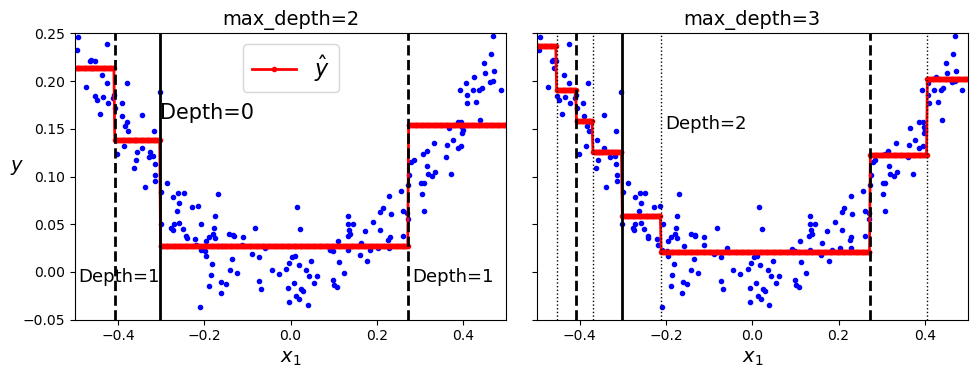

In [27]:
# extra code – this cell generates and saves Figure

def plot_regression_predictions(tree_reg, X, y, axes=[-0.5, 0.5, -0.05, 0.25]):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$")
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg, X_quad, y_quad)

th0, th1a, th1b = tree_reg.tree_.threshold[[0, 1, 4]]
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
plt.text(th0, 0.16, "Depth=0", fontsize=15)
plt.text(th1a + 0.01, -0.01, "Depth=1", horizontalalignment="center", fontsize=13)
plt.text(th1b + 0.01, -0.01, "Depth=1", fontsize=13)
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center", fontsize=16)
plt.title("max_depth=2")

plt.sca(axes[1])
th2s = tree_reg2.tree_.threshold[[2, 5, 9, 12]]
plot_regression_predictions(tree_reg2, X_quad, y_quad)
for split, style in ((th0, "k-"), (th1a, "k--"), (th1b, "k--")):
    plt.plot([split, split], [-0.05, 0.25], style, linewidth=2)
for split in th2s:
    plt.plot([split, split], [-0.05, 0.25], "k:", linewidth=1)
plt.text(th2s[2] + 0.01, 0.15, "Depth=2", fontsize=13)
plt.title("max_depth=3")

save_fig("tree_regression_plot")
plt.show()

CART算法的工作原理如前面所述，除了它现在不是试图以最小化不纯度的方式分割训练集，而是试图以最小化 MSE 的方式分割训练集。如下公式给出了算法试图最小化的代价函数。

**回归的 CART 成本函数**：

$$ J(k,t_k)=\frac{m_{left}}{m}MSE_{left}+\frac{m_{right}}{m}MSE_{right} $$

其中：

- $MSE_{node}=\frac{\sum_{i\in node}(\hat{y}_{node}-y^{(i)})^2}{m_{node}}$
- $\hat{y}_{node}=\frac{\sum_{i\in node}y^{(i)}}{m_{node}}$

与分类任务一样，决策树在处理回归任务时也容易发生过拟合。如果没有任何正则化（例如，使用默认的超参数表），您可以得到下图中左侧的预测。这些预测显然对训练集的过拟合非常糟糕。仅仅设置 **min_samples_leaf=10** 就会得到一个更合理的模型，如下图的右边所示。

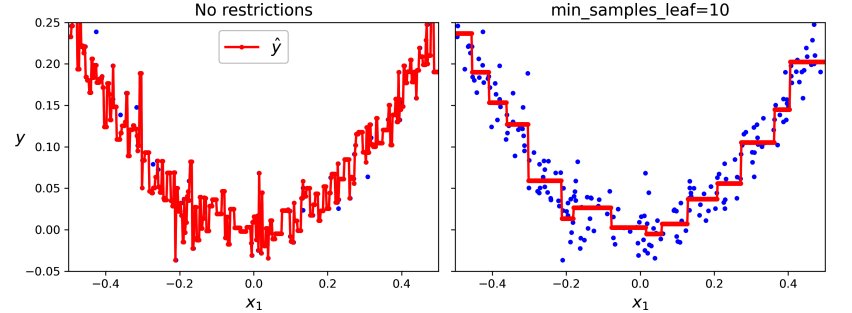

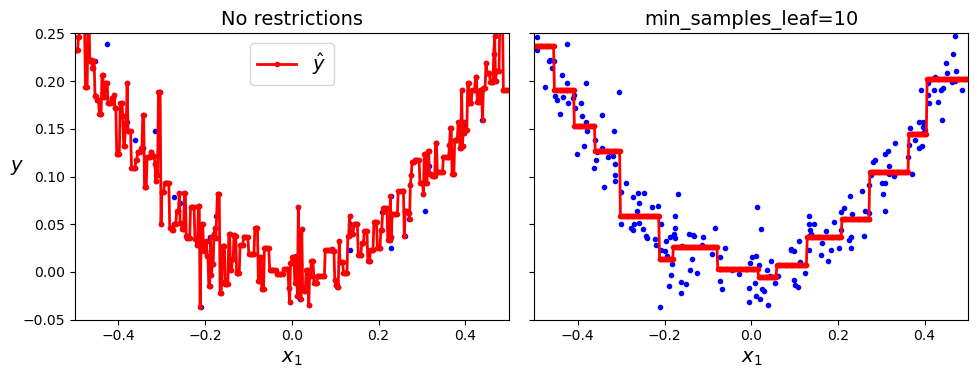

In [28]:
# extra code – this cell generates and saves Figure 6–6

tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X_quad, y_quad)
tree_reg2.fit(X_quad, y_quad)

x1 = np.linspace(-0.5, 0.5, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper center")
plt.title("No restrictions")

plt.sca(axes[1])
plt.plot(X_quad, y_quad, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([-0.5, 0.5, -0.05, 0.25])
plt.xlabel("$x_1$")
plt.title(f"min_samples_leaf={tree_reg2.min_samples_leaf}")

save_fig("tree_regression_regularization_plot")
plt.show()

## 9. 轴向敏感性（Sensitivity to Axis Orientation）

希望您现在已经相信决策树有很多优点：它们相对容易理解和解释，易于使用，用途广泛，功能强大。然而，它们确实有一些限制。首先，正如您可能已经注意到的那样，决策树喜欢正交的决策边界（所有的分割都垂直于一个轴），这使得它们对数据的方向很敏感。

例如，下图显示了一个简单的线性可分数据集：在左边，决策树可以很容易地分割它，而在右边，在数据集旋转 45°后，决策边界看起来不必要地复杂。虽然两种决策树都完全适合训练集，但右边的模型很可能不能很好地泛化。

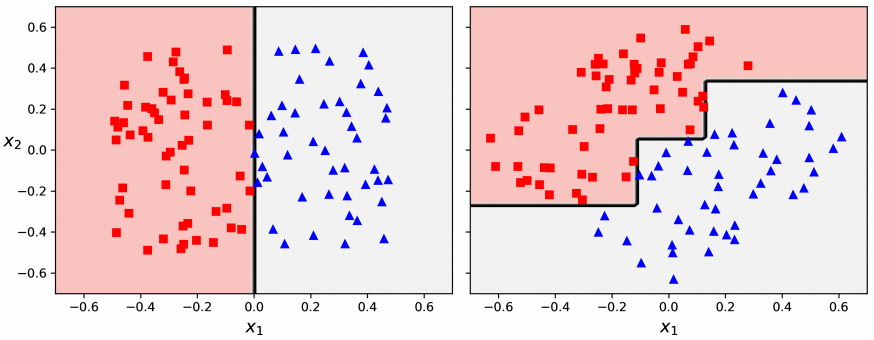

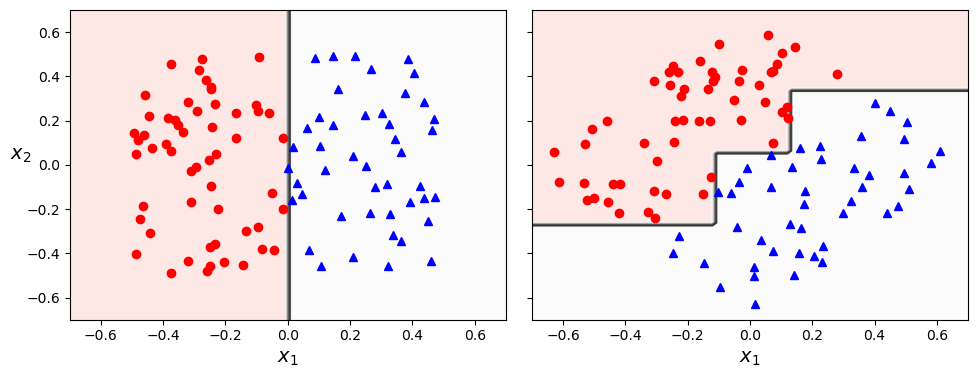

In [29]:
# extra code – this cell generates and saves Figure 6–7

np.random.seed(6)
X_square = np.random.rand(100, 2) - 0.5
y_square = (X_square[:, 0] > 0).astype(np.int64)

angle = np.pi / 4  # 45 degrees
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
X_rotated_square = X_square.dot(rotation_matrix)

tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square, y_square)
tree_clf_rotated_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotated_square.fit(X_rotated_square, y_square)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_square, X_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.sca(axes[1])
plot_decision_boundary(tree_clf_rotated_square, X_rotated_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

限制此问题的一种方法是缩放数据，然后应用 **主成分分析（principal component analysis）** 转换。我们将在第 8 章详细介绍 PCA，但现在您只需要知道它以降低特征之间相关性的方式旋转数据，这通常（并非总是）使树的处理变得更容易。

让我们创建一个小管道，它缩放数据并使用 PCA 旋转它，然后对该数据训练一个 **DecisionTreeClassifier** 。下图显示了该树的决策边界：正如您所看到的，旋转使得仅使用一个特征 $z_1$ 就可以很好地拟合数据集，$z_1$ 是原始花瓣长度和宽度的线性函数。下面是代码：

In [30]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(StandardScaler(), PCA())

X_iris_rotated = pca_pipeline.fit_transform(X_iris)

tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)

tree_clf_pca.fit(X_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

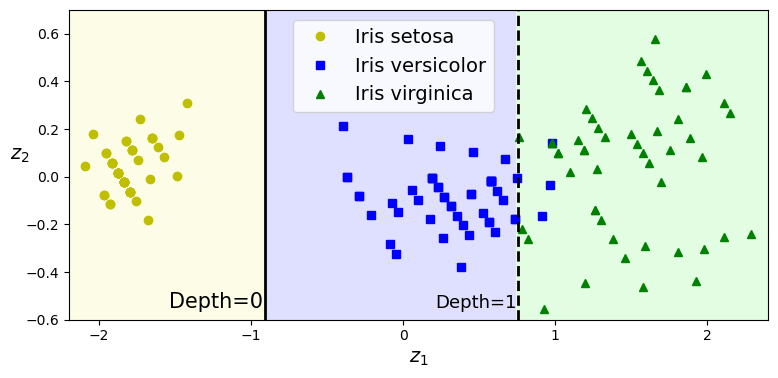

In [31]:
# extra code – this cell generates and saves Figure 6–8

plt.figure(figsize=(8, 4))

axes = [-2.2, 2.4, -0.6, 0.7]
z0s, z1s = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                       np.linspace(axes[2], axes[3], 100))
X_iris_pca_all = np.c_[z0s.ravel(), z1s.ravel()]
y_pred = tree_clf_pca.predict(X_iris_pca_all).reshape(z0s.shape)

plt.contourf(z0s, z1s, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris_rotated[:, 0][y_iris == idx],
             X_iris_rotated[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
th1, th2 = tree_clf_pca.tree_.threshold[[0, 2]]
plt.plot([th1, th1], axes[2:], "k-", linewidth=2)
plt.plot([th2, th2], axes[2:], "k--", linewidth=2)
plt.text(th1 - 0.01, axes[2] + 0.05, "Depth=0",
         horizontalalignment="right", fontsize=15)
plt.text(th2 - 0.01, axes[2] + 0.05, "Depth=1",
         horizontalalignment="right", fontsize=13)
plt.axis(axes)
plt.legend(loc=(0.32, 0.67))
save_fig("pca_preprocessing_plot")

plt.show()

## 10. 决策树有很大的方差（Decision Trees Have a High Variance）

更一般地说，决策树的主要问题是它们具有相当高的方差：超参数或数据的微小变化可能会产生非常不同的模型。事实上，由于 Scikit-Learn 使用的训练算法是随机的——它随机选择一组特征来评估每个节点——即使在完全相同的数据上重新训练相同的决策树也可能会产生一个非常不同的模型，例如如下图所示（除非设置 **random_state** 超参数）。如您所见，它看起来与之前的决策树非常不同。

In [32]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)

tree_clf_tweaked.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=40)

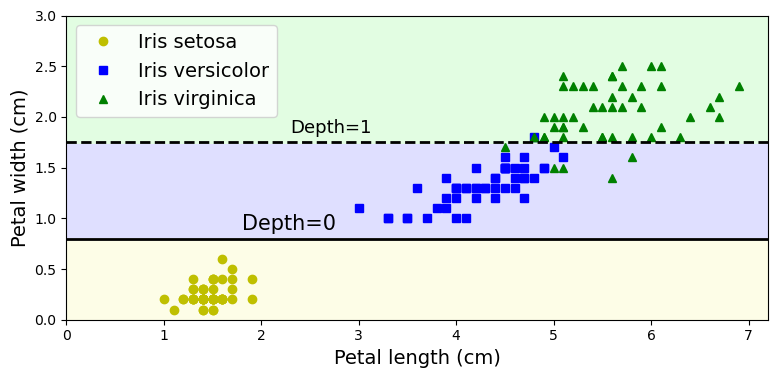

In [33]:
# extra code – this cell generates and saves Figure 6–9

plt.figure(figsize=(8, 4))
y_pred = tree_clf_tweaked.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)

for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

th0, th1 = tree_clf_tweaked.tree_.threshold[[0, 2]]
plt.plot([0, 7.2], [th0, th0], "k-", linewidth=2)
plt.plot([0, 7.2], [th1, th1], "k--", linewidth=2)
plt.text(1.8, th0 + 0.05, "Depth=0", verticalalignment="bottom", fontsize=15)
plt.text(2.3, th1 + 0.05, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.axis([0, 7.2, 0, 3])
plt.legend()
save_fig("decision_tree_high_variance_plot")

plt.show()

之前的结果：

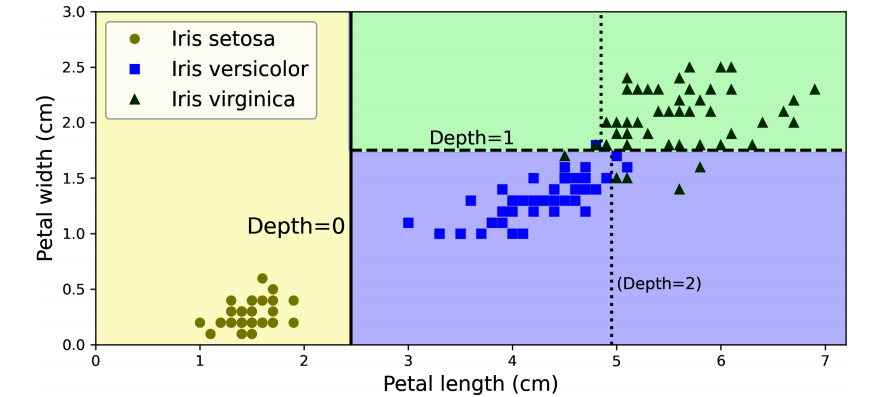

幸运的是，通过对许多树的预测进行平均，就有可能显著地减少方差。这样的树的集合被称为随机森林，它是今天可用的最强大的模型类型之一，正如您将在下一章中看到。

## 11. 额外材料——访问树结构

经过训练的 **DecisionTreeClassifier** 具有存储树结构的 **tree_** 属性：

In [34]:
tree = tree_clf.tree_
tree

您可以获得树中的节点总数：

In [35]:
tree.node_count

5

其他不言自明的属性可用：

In [36]:
tree.max_depth

2

In [37]:
tree.max_n_classes

3

In [38]:
tree.n_features

2

In [39]:
tree.n_outputs

1

In [40]:
tree.n_leaves

3

所有关于节点的信息都存储在 NumPy 数组中。 例如，每个节点的不纯度：

In [41]:
tree.impurity

array([0.66666667, 0.        , 0.5       , 0.16803841, 0.04253308])

根节点位于索引0。节点 $i$ 的左右子节点是 `tree.children_left[i]` 和 `tree.children_right[i]` 。例如，根节点的子节点是：

In [42]:
tree.children_left[0], tree.children_right[0]

(1, 2)

当左右节点相等时，表示这是一个叶节点（子节点 id 是任意的）：

In [43]:
tree.children_left[3], tree.children_right[3]

(-1, -1)

所以你可以像这样得到叶子节点的 id ：

In [44]:
is_leaf = (tree.children_left == tree.children_right)
np.arange(tree.node_count)[is_leaf]

array([1, 3, 4])

非叶节点称为分裂节点。他们拆分的特征可通过特征数组获得。叶节点的值应该被忽略：

In [48]:
tree.feature

array([ 0, -2,  1, -2, -2], dtype=int64)

相应的阈值是：

In [49]:
tree.threshold

array([ 2.44999999, -2.        ,  1.75      , -2.        , -2.        ])

并且每个类到达每个节点的实例数也可用：

In [50]:
tree.value

array([[[50., 50., 50.]],

       [[50.,  0.,  0.]],

       [[ 0., 50., 50.]],

       [[ 0., 49.,  5.]],

       [[ 0.,  1., 45.]]])

In [51]:
tree.n_node_samples

array([150,  50, 100,  54,  46], dtype=int64)

In [52]:
np.all(tree.value.sum(axis=(1, 2)) == tree.n_node_samples)

True

以下是计算每个节点深度的方法：

In [53]:
def compute_depth(tree_clf):
    tree = tree_clf.tree_
    depth = np.zeros(tree.node_count)
    stack = [(0, 0)]
    while stack:
        node, node_depth = stack.pop()
        depth[node] = node_depth
        if tree.children_left[node] != tree.children_right[node]:
            stack.append((tree.children_left[node], node_depth + 1))
            stack.append((tree.children_right[node], node_depth + 1))
    return depth

depth = compute_depth(tree_clf)

depth

array([0., 1., 1., 2., 2.])

以下是获取深度为1的所有分裂节点的阈值的方法：

In [54]:
tree_clf.tree_.feature[(depth == 1) & (~is_leaf)]

array([1], dtype=int64)

In [55]:
tree_clf.tree_.threshold[(depth == 1) & (~is_leaf)]

array([1.75])